In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glm_model as gm
from glm_utils import *
from scipy.stats import linregress
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%matplotlib inline

boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

<font face = 'Computer Modern', size = 3>

<ul> plan of action 

<li >download ~ 100 cells from 1 experiment. i.e. primary visual cortex, layer 2/3. (Make it easy to change in code which experiment) </li>

<li>all of these cells should be significantly modulated by natural scenes (whatever that means) - ie time to peak ~50-150 ms... </li>

<li>this means *each cell* will have the *same* design matrix. </li>

<li>go through and make tensor for all cells to calculate slope and goodness of fit of linear mean vs. std-deviation curve </li>

<li>store traces in dictionary with key that is cell id. </li>

<li>store parameters of learned model in a dictionary, key is cell id. (need initial weight matrix, final weight matrix, scale, offset) </li>

<li>final deliverable: histogram of R^2's for all model types </li>


In [2]:
import pandas as pd

# Download experiment containers for VISp experiments, with imaging depth 350 
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'], imaging_depths = [350], cre_lines=['Scnn1a-Tg3-Cre'])
print("Experiment containers: %d" % len(visp_ecs))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("Layer 4 cells from primary visual cortex: %d" % len(visp_cells))


ns_cells = visp_cells[(visp_cells['p_ns'] < 0.05) & (visp_cells['p_ns'] > 0.0) & 
                      (visp_cells['time_to_peak_ns'] > 0.001) & visp_cells['time_to_peak_ns'] < 1]

print("Cells that with significant response to natural scenes: %d" % len(ns_cells))

Experiment containers: 3
total cells: 18260
VISp, SCnn1a, 350um imaging depth cells: 923
Cells that with significant response to natural scenes: 340


In [52]:
#ie there are 127 cells from experiment container id 511498742 with'significant 
sum([c['experiment_container_id'] == visp_ecs[0]['id'] for i, c in ns_cells.iterrows()])

134

In [53]:
visp_ecs[0]['id']

511510911

In [54]:
#just look at cells from the first experiment container
exp = boc.get_ophys_experiments(experiment_container_ids=[visp_ecs[0]['id']], stimuli = [stim_info.NATURAL_SCENES])
data_set = boc.get_ophys_experiment_data(exp[0]['id'])


In [55]:
#get all the traces. 
#WRITE THIS IN A MORE EFFICIENT WAY!!!

from allensdk.brain_observatory.dff import compute_dff


dff_dict = {}

for cell_s in data_set.get_cell_specimen_ids():
    for cell_can in ns_cells['cell_specimen_id']:
        if cell_s == cell_can:
            time, corrected_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[cell_s])
            dff_dict[cell_s] = np.squeeze(compute_dff(np.array(corrected_traces))[0])


In [56]:
# read in the array of images
#get the stimulus
scenes = data_set.get_stimulus_template('natural_scenes')
stim_table = data_set.get_stimulus_table(stim_info.NATURAL_SCENES)


In [57]:
len(dff_dict)

21

In [9]:
#we make the design matrix, and corresponding dff array - using the stimulus table to tell us when a natural image was presented.
#we resize the stimulus to a 20 by 20 image. 
import cv2
from scipy.stats import norm


m = np.mean(scenes)
sig = np.std(scenes)

scenes = (scenes - m)/sig

stim_array = []

data = {k: [] for k in dff_dict.keys()}

H = 20
W = 20

for index, row in stim_table.iterrows():
    for i in range(row['start'], row['end']):
        stim_array.append(cv2.resize(scenes[row.frame,:,:], (H, W)))
        for c in dff_dict.keys():
            data[c].append(dff_dict[c][i])
            
        

stim_array = np.array(stim_array).reshape([-1, H*W])

n = 20
basis = norm.pdf(range(0, n), loc = n/2, scale = n/8)

basis = basis[6:]
basis[0:4] = 0
basis /= sum(basis)

l, n = stim_array.shape

for i in range(n):
    stim_array[:, i] = np.squeeze(np.convolve(stim_array[:, i], basis)[0:l])

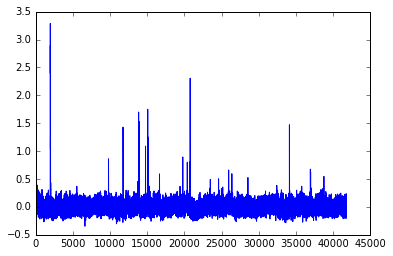

In [10]:
#plot one example just to make sure shit makes sense
plt.plot(data[c])

In [58]:
#Go through and fit each model
from sklearn.cross_validation import train_test_split


params = {}

for c in data.keys():
    
    X_train, X_test, y_train, y_test = train_test_split(stim_array, np.array(data[c]))
    
    weight_init = inv_design = np.linalg.pinv(X_train).dot(y_train)
    
    model = gm.exponential_GLM(400, weight_init.reshape([400, 1]), alpha = 0,
                               non_lin = tf.exp, lr = .001, bias_init = 0, 
                            scale_init= .4, train_params = True)

    training_loss, test_loss  = model.fit(X_train, y_train[:, np.newaxis], X_test, y_test[:, np.newaxis], batch_size = 10000, max_iters=1000)
    
    w, o, s  = model.get_params()
    
    _, _, r_value_fit,_, _ = linregress(np.squeeze(cond_int(np.exp, w, X_test, s, o)), np.squeeze(y_test))

    _, _, r_value,_, _ = linregress(np.squeeze(X_test.dot(weight_init)), np.squeeze(y_test))
    
    params[c] = (w, o, s, r_value_fit**2, r_value**2)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:38
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:37
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:38
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:35
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:33
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:33
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:33
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:34
0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:01:34
0

In [12]:
ols_r = []
glm_r = []

for c in params.keys():
    w, o, s, r_value_fit, r_value = params[c]
    
    ols_r.append(r_value)
    glm_r.append(r_value_fit)
    

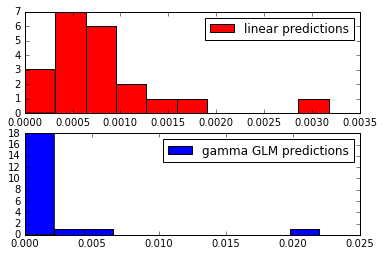

In [27]:
plt.subplot(211)
plt.hist(np.array(ols_r), color = 'r', label = 'linear predictions')
plt.legend()
plt.subplot(212)
plt.hist(np.array(glm_r), color = 'b', label = 'gamma GLM predictions')
plt.legend()
plt.show()

In [26]:
print np.mean(ols_r), np.std(ols_r), np.mean(glm_r), np.std(glm_r)

0.000771112477142 0.000668970434637 0.0017264794733 0.00467341925073
